Points covered:
1. Time series graphics
2. Time series decomposition
3. Time series feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# Accessinng Kaggle dataset
from google.colab import userdata
import os
import zipfile

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d robikscube/hourly-energy-consumption

# Unzip our data
zip_ref = zipfile.ZipFile('hourly-energy-consumption.zip', 'r')
zip_ref.extractall()
zip_ref.close()

hourly-energy-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Reading data
df = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
df = df[~df.index.duplicated(keep='first')]
df = df.sort_index()

Simple statistics

In [4]:
df['PJME_MW'].describe()

count    145362.000000
mean      32080.505139
std        6463.874131
min       14544.000000
25%       27573.000000
50%       31421.000000
75%       35650.000000
max       62009.000000
Name: PJME_MW, dtype: float64

# **0. Definitions of time series patterns**

- **Trend**: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “*changing direction*”, when it might go from an increasing trend to a decreasing trend.
- **Seasonal**: A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known period.
- **Cyclic**: A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.</br>

*Source: Forecasting: Principles and Practice (3rd ed)*

# **1. Time series graphics**

## 1.1. Time plot

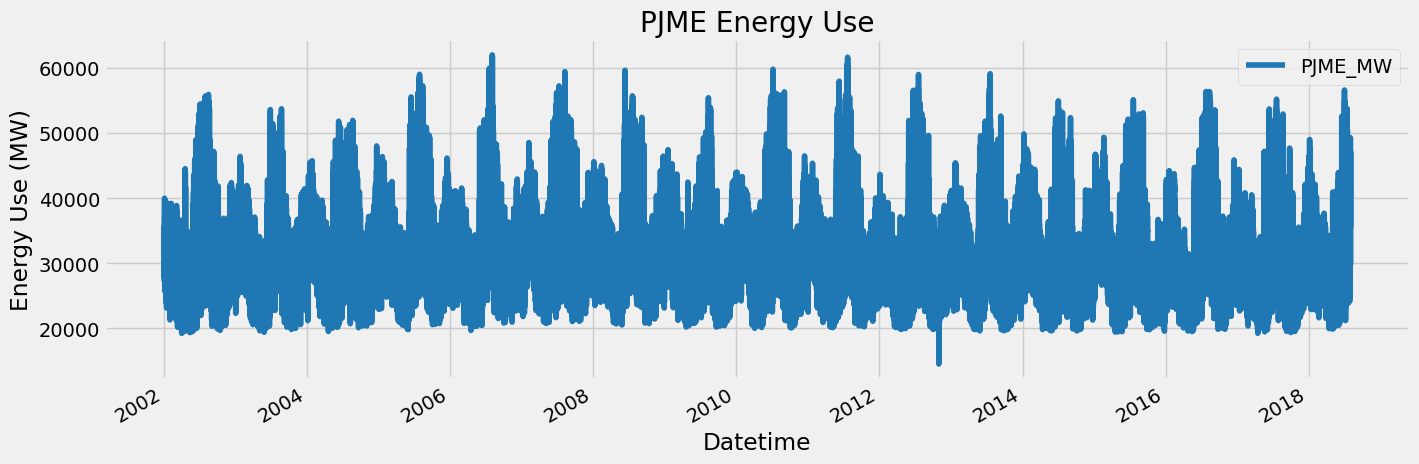

In [5]:
df.plot(figsize=(15,5), color=color_pal[0], title='PJME Energy Use')
plt.ylabel('Energy Use (MW)')
plt.show()

The PJME data shows strong seasonality, but There is no apparent trend in the data.

## 1.2. Seasonal plots

### 1.2.1. Monthly seasonal  patterns

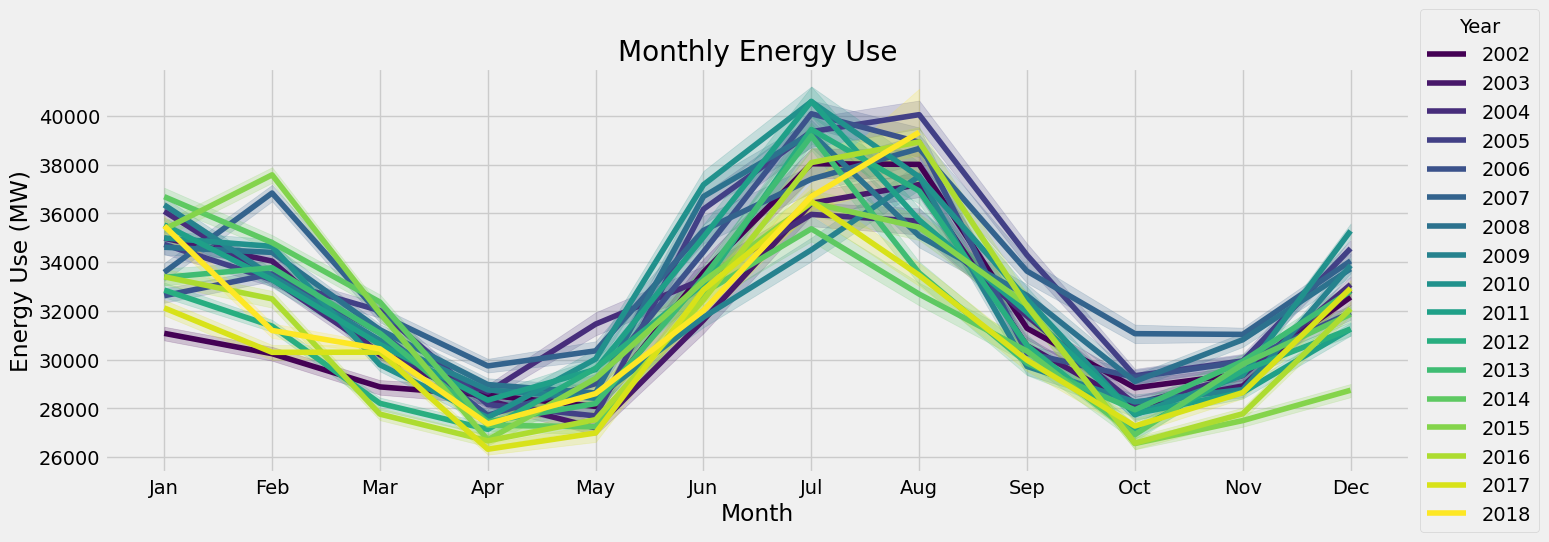

In [6]:
df['year'] = df.index.year
df['month'] = df.index.strftime('%b')
df['day_of_week'] = df.index.strftime('%a')
df['hour'] = df.index.hour.astype(str)
df['quarter'] = 'Q' + df.index.quarter.astype(str)


fig, ax = plt.subplots(figsize=(15,5))
lineplot = sns.lineplot(data=df, x='month', y='PJME_MW', hue='year', palette='viridis', ax=ax)
years = [str(year) for year in df['year'].unique()]
legend_handles = lineplot.get_lines()
ax.legend(handles=legend_handles, labels=years, title='Year', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Monthly Energy Use')
ax.set_xlabel('Month')
ax.set_ylabel('Energy Use (MW)')
plt.plot();

The graph reveals that in summer and winter, there is high energy consumption.

### 1.2.2. Weekly seasonal patterns

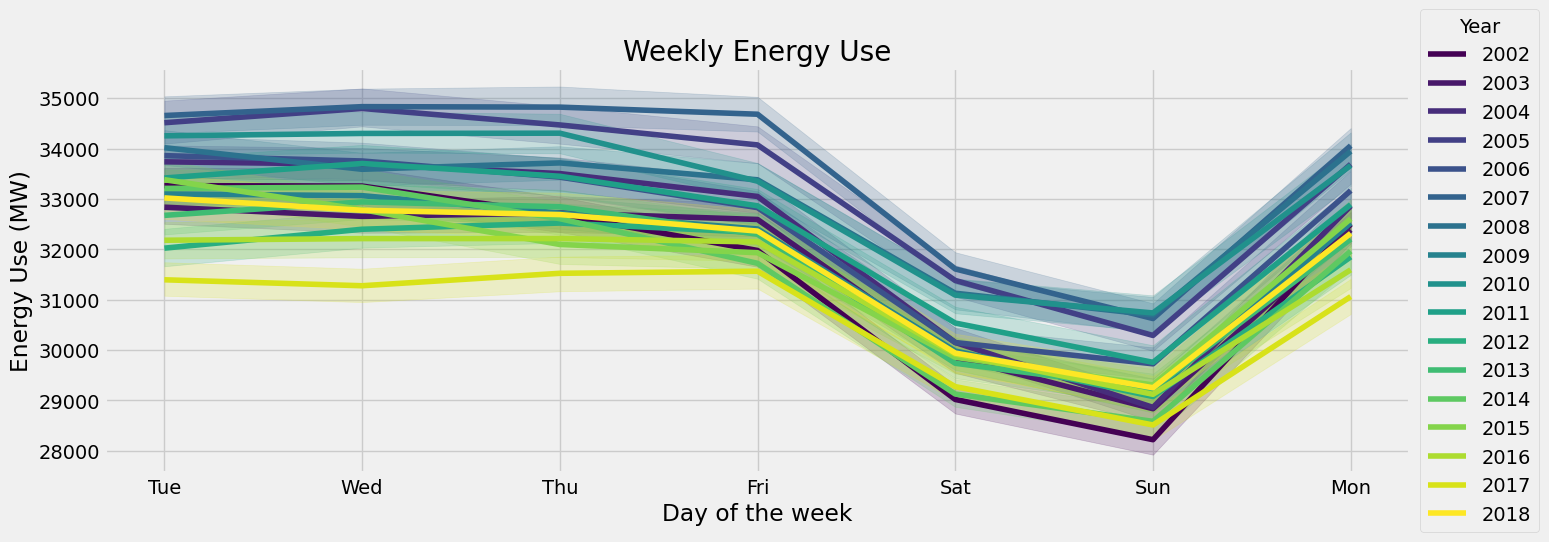

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
lineplot = sns.lineplot(data=df, x='day_of_week', y='PJME_MW', hue='year', palette='viridis', ax=ax)
years = [str(year) for year in df['year'].unique()]
legend_handles = lineplot.get_lines()
ax.legend(handles=legend_handles, labels=years, title='Year', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Weekly Energy Use')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Energy Use (MW)')
plt.plot();

Energy consumption is lowest during the weekend.

### 1.1.3. Daily seasonal patters

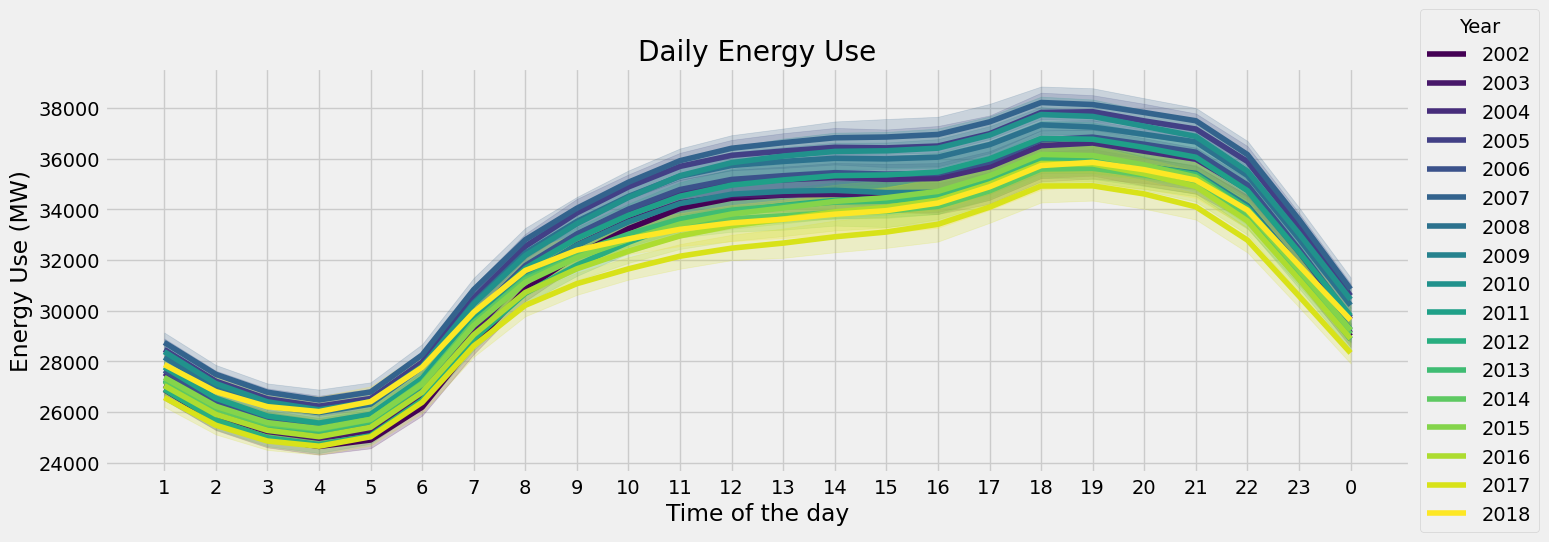

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
lineplot = sns.lineplot(data=df, x='hour', y='PJME_MW', hue='year', palette='viridis', ax=ax)
years = [str(year) for year in df['year'].unique()]
legend_handles = lineplot.get_lines()
ax.legend(handles=legend_handles, labels=years, title='Year', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Daily Energy Use')
ax.set_xlabel('Time of the day')
ax.set_ylabel('Energy Use (MW)')
plt.plot();

### 1.2.4. Quaterly seasonal patterns

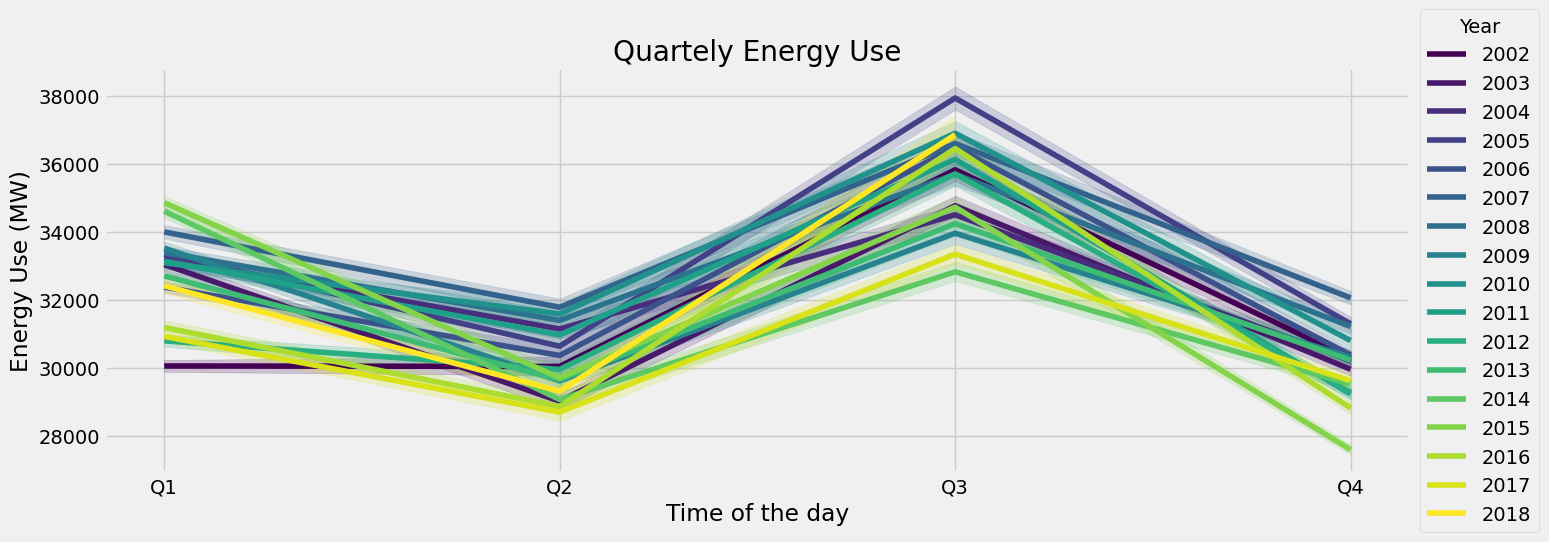

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
lineplot = sns.lineplot(data=df, x='quarter', y='PJME_MW', hue='year', palette='viridis', ax=ax)
years = [str(year) for year in df['year'].unique()]
legend_handles = lineplot.get_lines()
ax.legend(handles=legend_handles, labels=years, title='Year', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Quartely Energy Use')
ax.set_xlabel('Time of the day')
ax.set_ylabel('Energy Use (MW)')
plt.plot();

### 1.2.5. Seasonal subseries plots

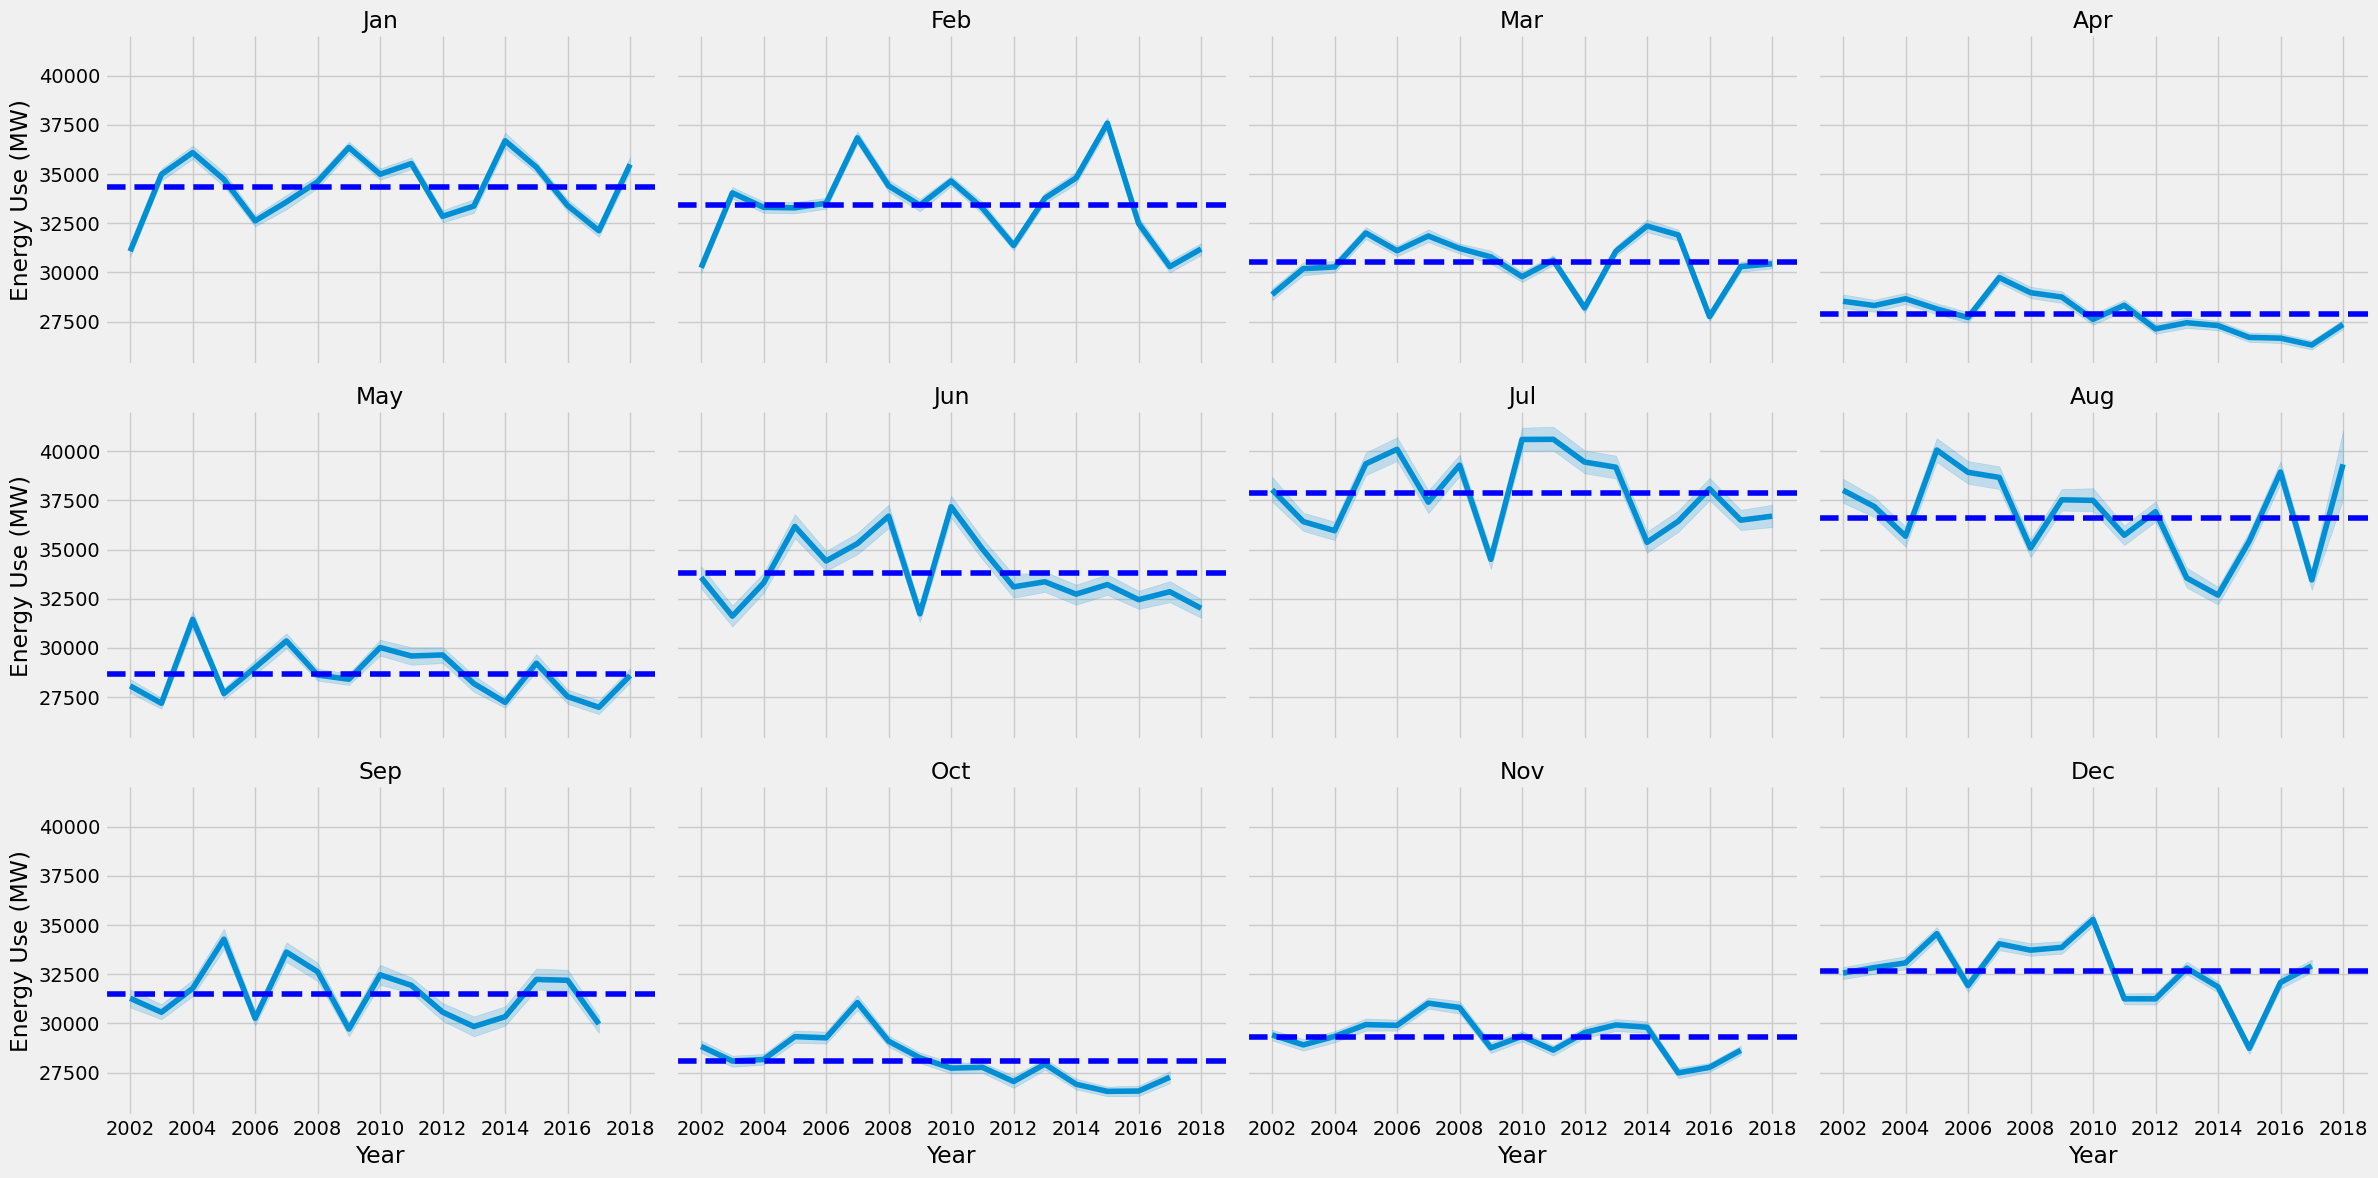

In [10]:
g = sns.FacetGrid(df, col="month", col_wrap=4, height=4, aspect=1.5)
g = g.map(sns.lineplot, "year", "PJME_MW")

for ax in g.axes.flat:
    median_sales = df.loc[df['month'] == ax.get_title().partition(' = ')[-1], 'PJME_MW'].mean()
    ax.axhline(median_sales, color='blue', ls='--')

g.set_axis_labels('Year', 'Energy Use (MW)')
g.set_titles('{col_name}')
plt.show()

There is no clear pattern in energy consumption segmented by month across all years. The blue horizontal lines indicate the means for each month.

## 1.3. Scatterplots.
Had we had other variables like weather information, we could use scatter plots to visualise the relationship between the variables.

## 1.4. Lag plots

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


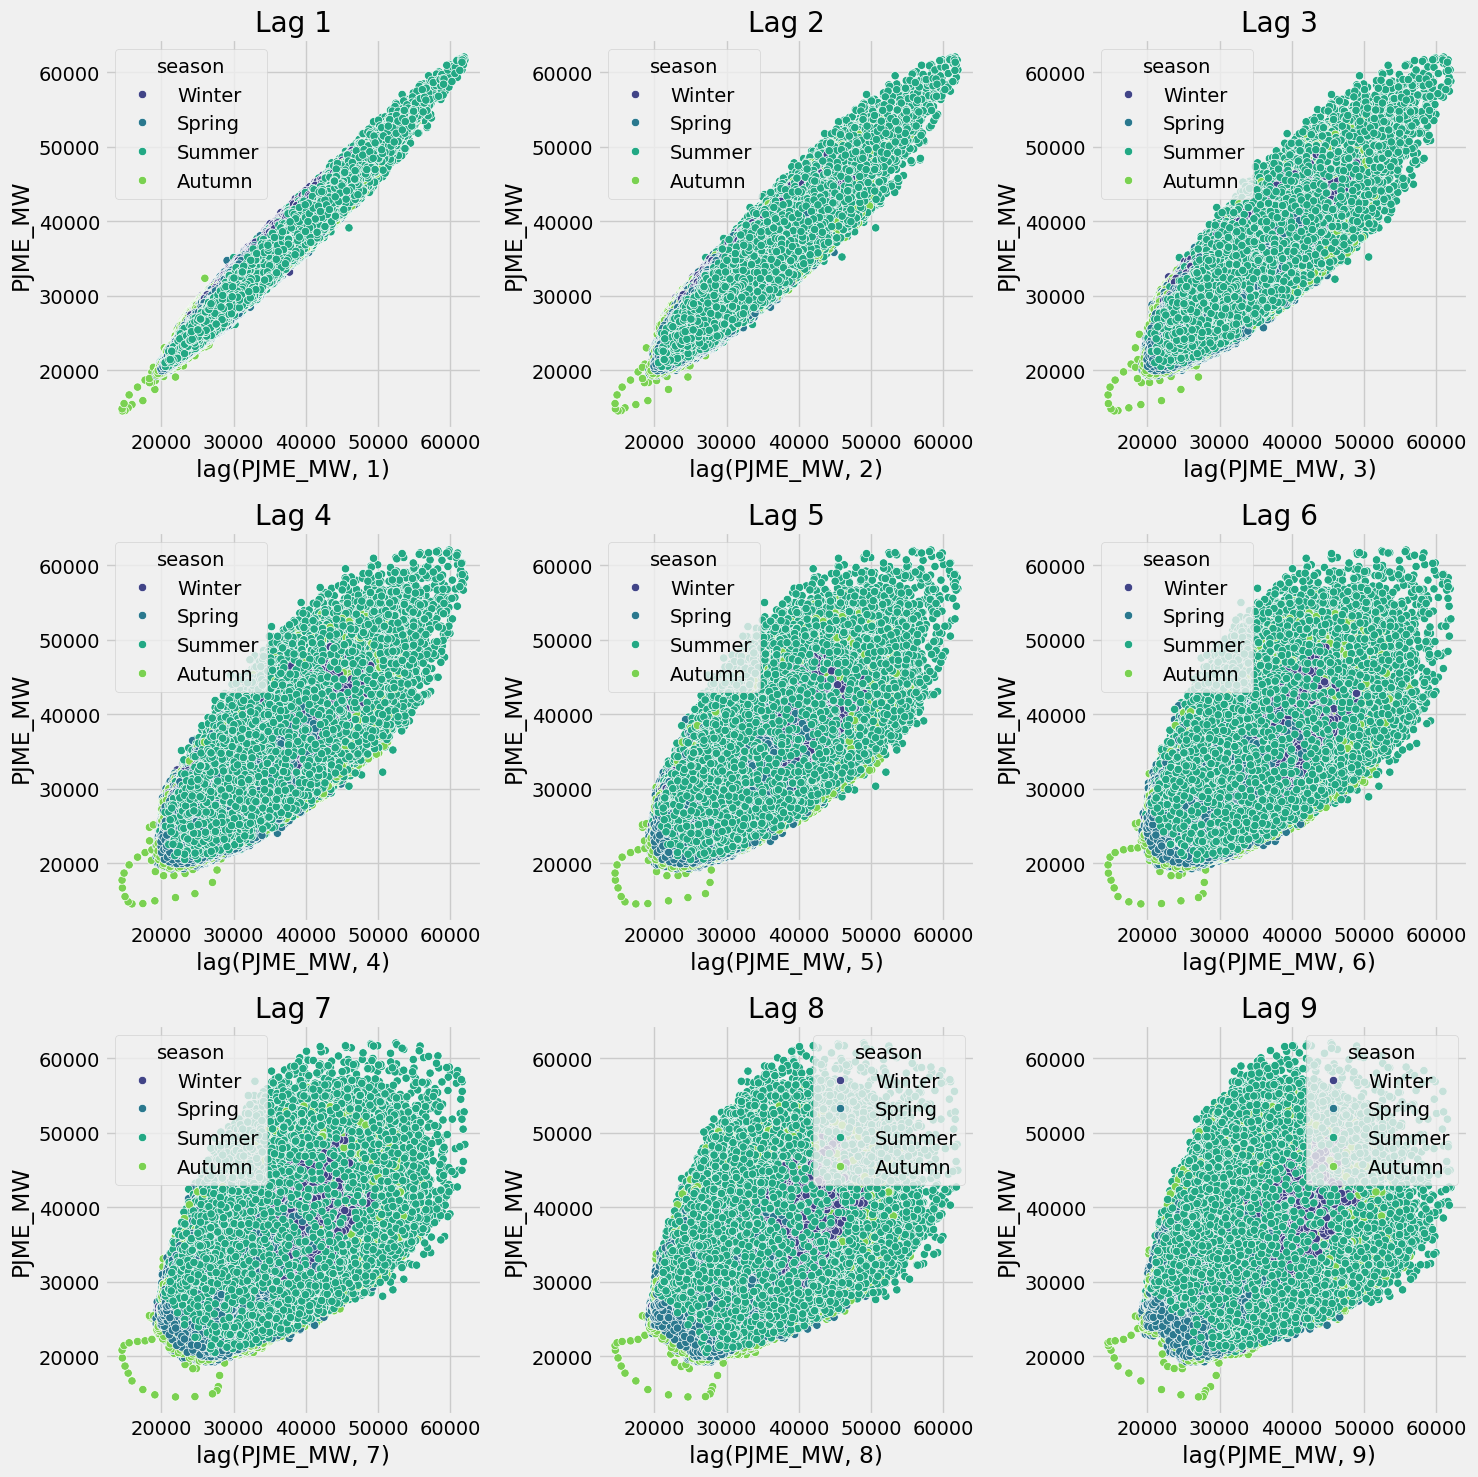

In [11]:
def get_season(month):
    if month in ['Dec', 'Jan', 'Feb']:
        return 'Winter'
    elif month in ['Mar', 'Apr', 'May']:
        return 'Spring'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'


df_for_lags = df.copy()
df_for_lags['season'] = df_for_lags['month'].apply(get_season)

max_lags = 9
for lag in range(1, max_lags + 1):
    df_for_lags[f'lag_{lag}'] = df_for_lags['PJME_MW'].shift(lag)

df_for_lags = df_for_lags.dropna().copy()


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i in range(1, max_lags + 1):
    sns.scatterplot(x=f'lag_{i}', y='PJME_MW', data=df_for_lags, ax=axes[i-1], hue='season', palette='viridis')
    axes[i-1].set_title(f'Lag {i}')
    axes[i-1].set_xlabel(f'lag(PJME_MW, {i})')
    axes[i-1].set_ylabel('PJME_MW')


plt.tight_layout()
plt.show()

We observe a strong correlation with 1 and 2-hour lags.

## 1.5. Autocorrelation function (ACF)

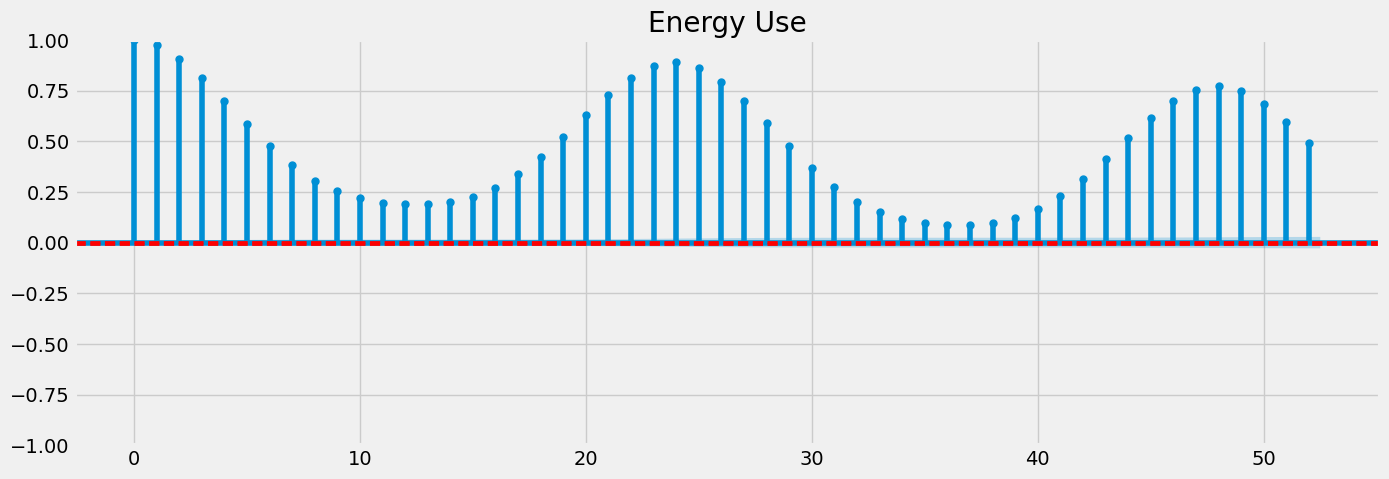

In [12]:
from statsmodels.graphics.tsaplots import plot_acf


T = len(df['PJME_MW'])
bound = 2 / np.sqrt(T)


fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(df['PJME_MW'], ax=ax,alpha=.05)
ax.axhline(y=bound, color='red', linestyle='--', lw=2)
ax.axhline(y=-bound, color='red', linestyle='--', lw=2)

# Add title and show plot
ax.set_title('Energy Use')
plt.show()

The initial positive autocorrelation at lag 1 suggests a strong correlation from one hour to the next, which quickly diminishes as the lag increases. The “scalloped” shape is due to the seasonality. As the data is in hourly intervals and the ACF plot shows a clear seasonal peak at lag 12, and then what appears to be another peak at lag 24, it suggests that there is a daily seasonality in the data.

Time series that show no autocorrelation are called **white noise**. For a white noise series, we expect 95% of the spikes in the ACF to lie within ±2/sqrt(T) where T is the length of the time series. The red dotted lines indicate these bounds.

# **2. Time series decomposition with STL**

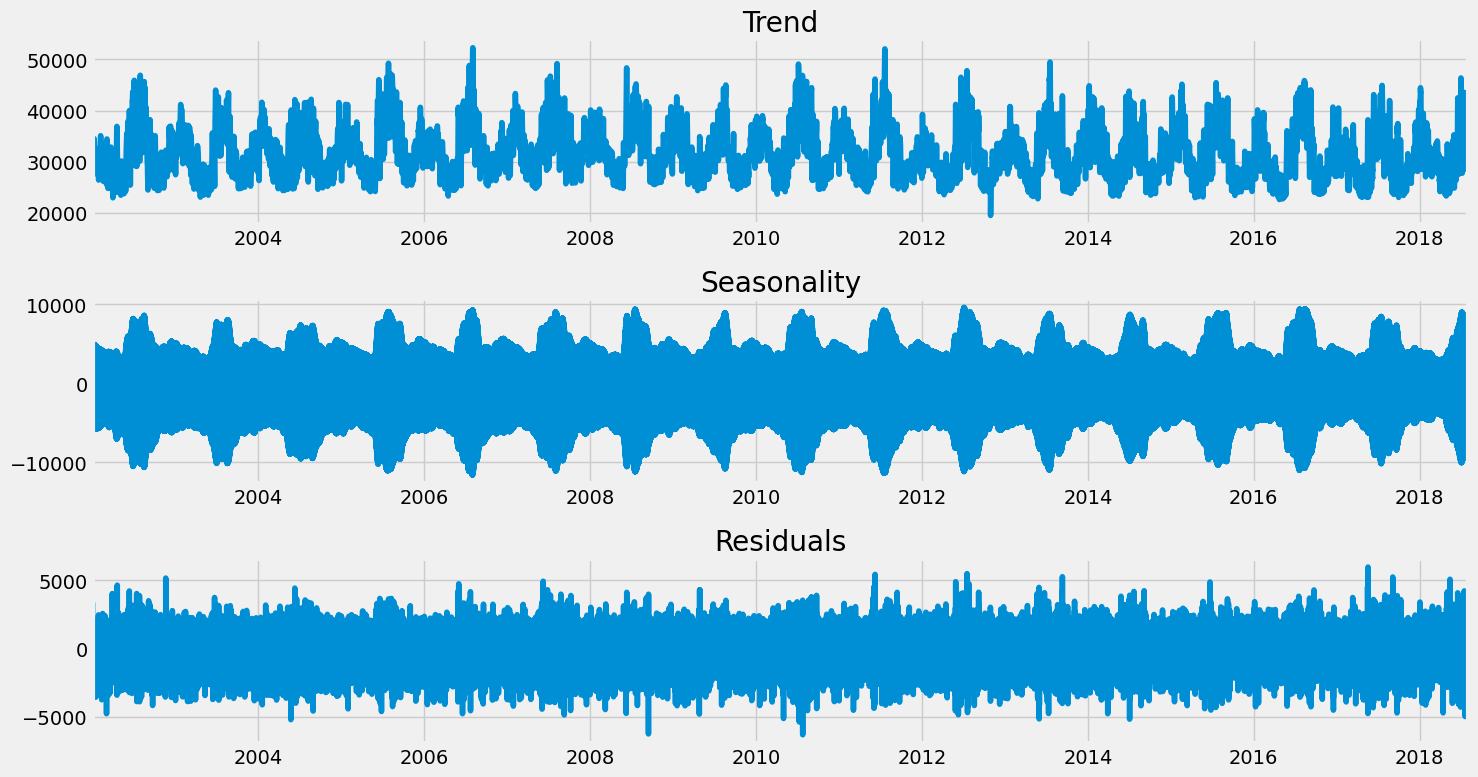

In [13]:
from statsmodels.tsa.seasonal import STL

data_for_stl = df[['PJME_MW']].copy()
data_for_stl.index = pd.date_range(start=data_for_stl.index.min(), periods=len(data_for_stl), freq='H')


data_for_stl = data_for_stl.asfreq('H')

stl = STL(data_for_stl['PJME_MW'], seasonal=23)  # seasonal=23 because we have a daily seasonality from the ACF plot.
res = stl.fit()

# Plot the decomposed components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))
res.trend.plot(ax=ax1, title='Trend')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.resid.plot(ax=ax3, title='Residuals')

plt.tight_layout()
plt.show()

The graph confirms that our data does not have any trend.

# **3. Time series feature engineering**

## 3.1. STL-based feature engineering


We can add trend and seasonality as additional features to our data. Since our data exhibits seasonality, I will only add the seasonal component.

In [14]:
df['STL'] = res.trend

## 3.2. Adding lags as additional features

Depending on the intended forecasting horizon, you may add hourly or yearly lags. In this example, I demonstrate how to add yearly lags. One drawback of using long lags is the creation of many NaN values, which may be detrimental in some cases

In [15]:
# Adding yearly lags
def add_lags(df):
    df = df.copy()
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

To be continued...